## Deliverable 1

Student ID's:

Andreea Roica: 20250361

Beatriz Varela: 20250367

Barbara Franco: 20250388

Marisa Esteves: 20250348

We will follow the CRISP-DM methodology.

## Business Understanding

The goal of this project is to create a regression model that can predict car prices based on its details. This includes:

- Regression Benchmarking
- Model Optimization
- Additional Insights

## Data Understanding

Metadata:

- **carID** : An attribute that contains an identifier for each car.
- **Brand** : The car’s main brand (e.g. Ford, Toyota).
- **model** : The car model.
- **year**: The year of Registration of the Car.
- **transmission** - Type of transmission of the car (e.g. Manual, Automatic, Semi-Automatic)
- **mileage** : The total reported distance travelled by the car (in miles).
- **tax** : The amount of road tax (in £) that, in 2020, was applicable to the car in question.
- **fuelType** : Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric).
- **mpg** : Average Miles per Gallon.
- **engineSize** : Size of Engine in liters (Cubic Decimeters).
- **paintQuality%** : The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).
- **previousOwners** : Number of previous registered owners of the vehicle.
- **hasDamage** : Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not.
- **price** : The car’s price when purchased by Cars 4 You (in £).

In [217]:
#!pip install fuzzywuzzy

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl 
import scipy as sp
from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, root_mean_squared_error

# Import fuzzywuzzy to correct the typos in 'Brand', 'fuelType' snd 'transmission'
from fuzzywuzzy import fuzz

# Import get_close_matches to identify and group similar words for typo correction in 'model'
from difflib import get_close_matches

# Import to perform the Chi-squared test
from scipy.stats import chi2_contingency



In [219]:
# Set seed
np.random.seed(33)

In [220]:
#Reading the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Characteristics of our data

In [221]:
df_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


We can already see that we have Null Values (at least in tax) and have strange values like negative previous owners

In [222]:
df_test.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


In [223]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


Identified Problems:

- Year and previousOwners is float when it should be integer
- hasDamage should be boolean instead of float

In [224]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB


### Duplicates

In [225]:
print('Check duplicates:')
print(f'Train: {df_train.duplicated().sum()}\nTest: {df_test.duplicated().sum()}')
print('\nCheck duplicates in carId:')
print(f'Train: {df_train.duplicated(subset='carID').sum()}\nTest: {df_test.duplicated(subset='carID').sum()}')

Check duplicates:
Train: 0
Test: 0

Check duplicates in carId:
Train: 0
Test: 0


### Categorical Variables

In [226]:
categorical_features = ['Brand', 'model', 'transmission', 'fuelType']

In [227]:
df_train.describe(include='object')

,Brand,model,transmission,fuelType
count,74452,74456,74451,74462
unique,72,735,40,34
top,Ford,Focus,Manual,Petrol
freq,14808,6353,38050,37995


In [228]:
for feat in categorical_features:
    print(f'{feat} :' )
    print(f'{pd.concat([df_train[feat], df_test[feat]]).unique().tolist()}\n')

Brand :
['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes', 'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', nan, 'yundai', 'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel', 'For', 'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD', 'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA', 'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod', 'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI', 'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede', 'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod', 'toyot', 'M', 'YUNDAI', 'oyot', 'bm']

model :
[' Golf', ' Yaris', ' Q2', ' FIESTA', ' 2 Series', '3 Series', ' A3', ' Octavia', ' Passat', ' Focus', ' Insignia', ' A Clas', ' Q3', ' Fabia', ' A Class', ' Ka+', ' 3 Series', ' GLC Class', ' I30', ' C Class', ' Polo', ' E Class', ' C Clas', ' Q5', ' Up', ' Fiesta', ' C-HR', ' Mokka X', ' Corsa', ' Astra', ' TT', ' 5 Series', ' Aygo', ' 4 Series', ' SLK'

**Histograms**

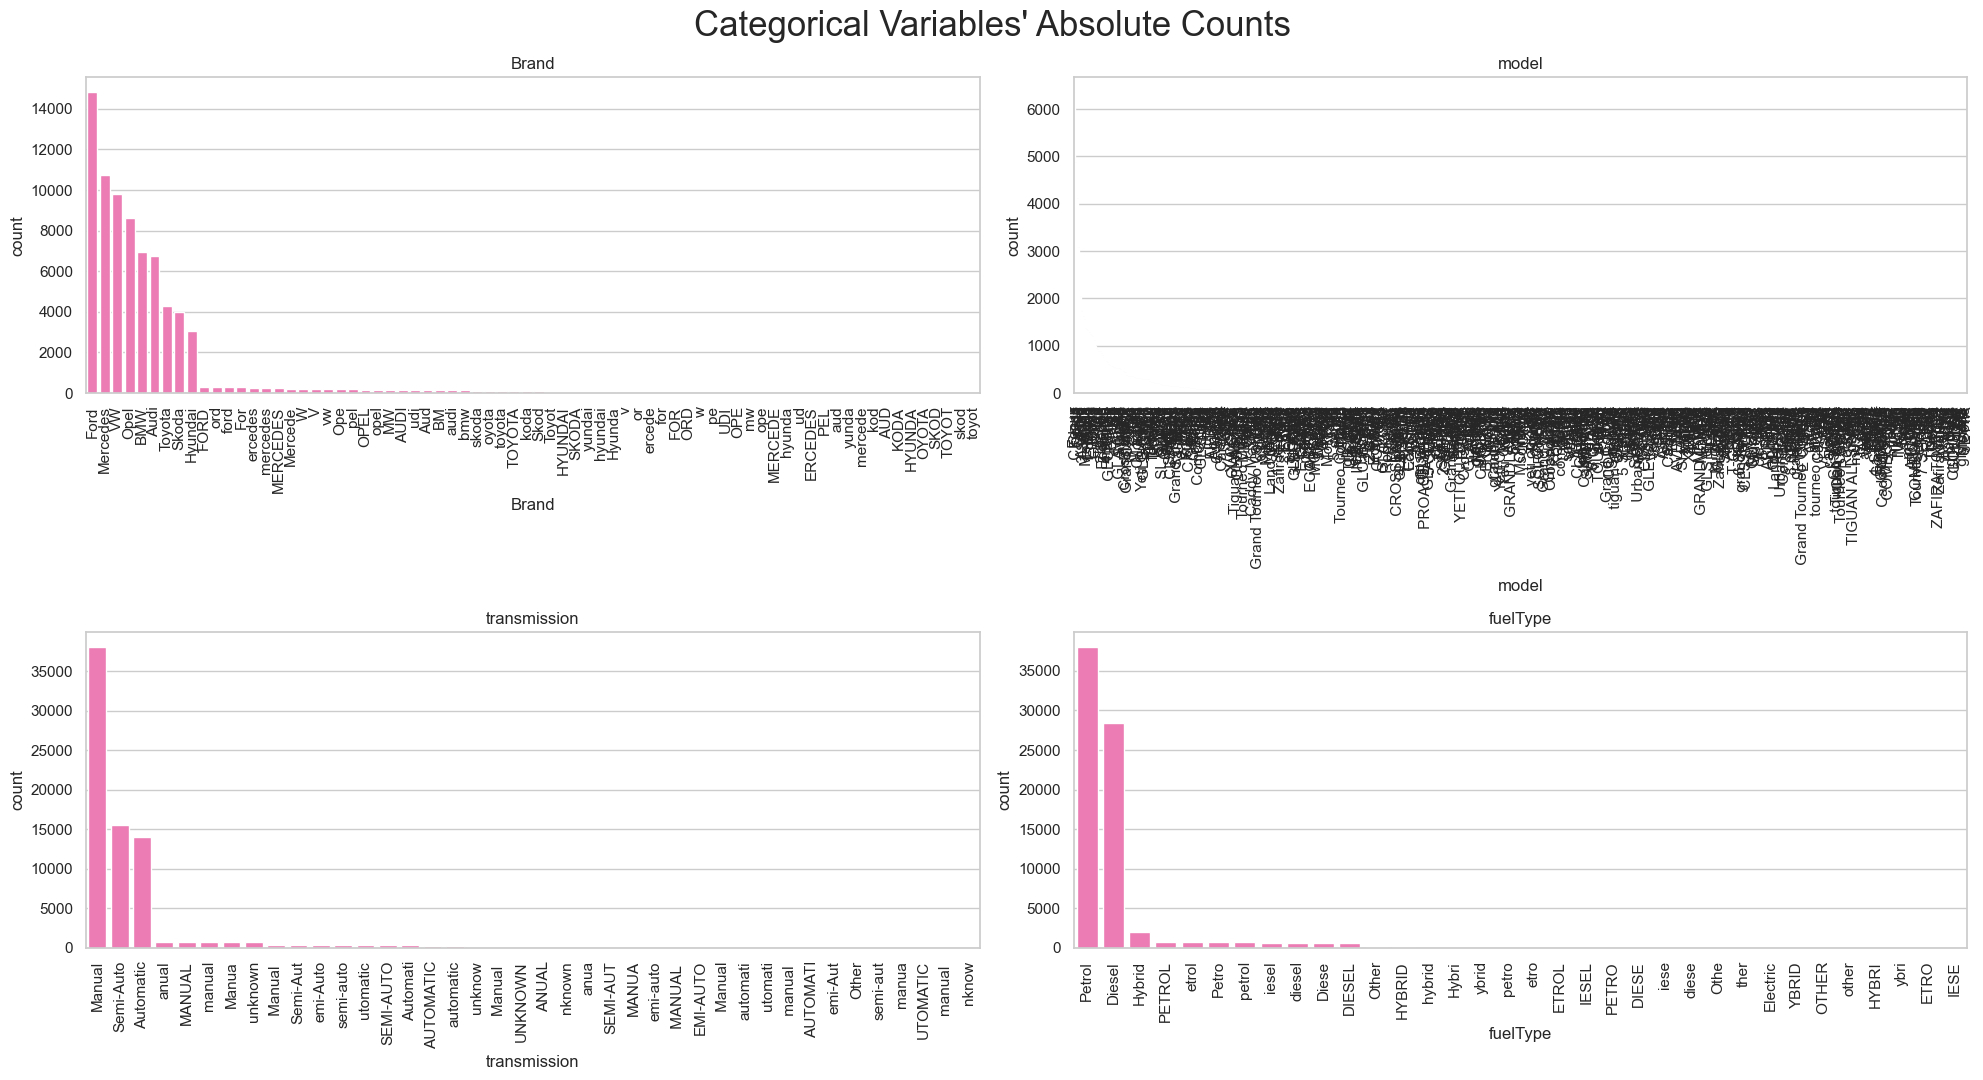

In [229]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, ceil(len(categorical_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), categorical_features):
    sns.countplot(x=df_train[feat], ax=ax, 
                  order=df_train[feat].value_counts().index, color = 'hotpink') 
    ax.set_title(feat)
    ax.tick_params(axis='x', rotation=90)  # roda os labels no eixo x


plt.suptitle("Categorical Variables' Absolute Counts", fontsize=25)

plt.tight_layout()
plt.show()

With these plots we can visualize the problems in the categorical variables, the huge amount of classes, most with very low frequency and simillar names. We will fix this in Data Preparation.

**Association between variables**

To evaluate the association between categorical (nominal) variables we will perfom the chi-squared test. 

H0: There is no evidence of a statistically significant association.

H1: There is a statistically significant association between the variables.

Interpretation:
- if p_value < 0.05 (significance level): Reject H0, so there is a statistically significant association between the {var1} and {var2}.
- if p_value >= 0.05 (significance level): Do not reject H0, so there is no evidence of a statistically significant association.

In [230]:
association_results = pd.DataFrame(columns=categorical_features, index=categorical_features)

def color_pvalues(val):

    #Apllies color coding to p-values.
    #Green: p-values < 0.05 (significant association).
    #Red: p-values >= 0.05 (no significant association).

    if val < 0.05:
        return 'background-color: lightgreen; color:black; border: 1px solid black;'
    else:
        return 'background-color: lightcoral; color:black; border: 1px solid black;'

for var1 in categorical_features:
    for var2 in categorical_features:
        #Chi-square test between {var1} and {var2}

        contingency_table = pd.crosstab(df_train[var1], df_train[var2]) # Create the contingency table
        result = chi2_contingency(contingency_table) # Perform the Chi-square test
                                                    #Chi-square Statistic: result[0]
                                                    #p-value: result[1]
                                                    #Degrees of Freedom: result[2]
                                                    #Expected Frequencies: result[3]
        association_results.loc[var1, var2] = result[1]

association_results= association_results.style.map(color_pvalues)
display(association_results)

,Brand,model,transmission,fuelType
Brand,0.000000,0.000000,0.000000,0.000000
model,0.000000,0.000000,0.000000,0.000000
transmission,0.000000,0.000000,0.000000,0.000000
fuelType,0.000000,0.000000,0.000000,0.000000


To measure their association we will use Cramer's V (suitable for nominal variables).

**Cramer's V = √(X2/N) / min(C-1, R-1)**

X2- Chi- squared statistics;

N- Total number of observations;

C- Number of columns in the contingency table;

R- Number of rows in the contingency table.

In [231]:
cramer_v_table = pd.DataFrame(columns=categorical_features, index = categorical_features)

for var1 in cramer_v_table.columns:
    for var2 in cramer_v_table.index:

        contingency_table = pd.crosstab(df_train[var1], df_train[var2])
        result = chi2_contingency(contingency_table)        

        # Calculate Cramer's V
        X2 = result[0]
        n = df_train.shape[0]
        minimum_dimension = min(df_train[var1].nunique(), df_train[var2].nunique())-1
        cramer_v_table.loc[var1, var2] = np.sqrt((X2/n) / minimum_dimension)

def color_cramervalues(val):
    if val > 0.6:
        return 'background-color: lightgreen; color:black; border: 1px solid black;'
    else:
        return 'background-color: lightcoral; color:black; border: 1px solid black;'


cramer_v_table= cramer_v_table.style.map(color_cramervalues)
display(cramer_v_table)

,Brand,model,transmission,fuelType
Brand,0.989939,0.338708,0.097623,0.099330
model,0.338708,0.989966,0.140960,0.192912
transmission,0.097623,0.140960,0.989933,0.071666
fuelType,0.099330,0.192912,0.071666,0.990006


The strength of the associations is low due to the number of typos that exist. 

### Numerical Variables

In [232]:
df_train = df_train.set_index ('carID')
df_test = df_test.set_index ('carID')

In [233]:
numeric_features = df_train.columns.drop(categorical_features)

In [234]:
df_train.describe()

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,74482.000000,75973.000000,74510.000000,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
mean,2017.096611,16881.889553,23004.184088,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,2.208704,9736.926322,22129.788366,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,2016.000000,10200.000000,7423.250000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,2017.000000,14699.000000,17300.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,20950.000000,32427.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


**Histograms**

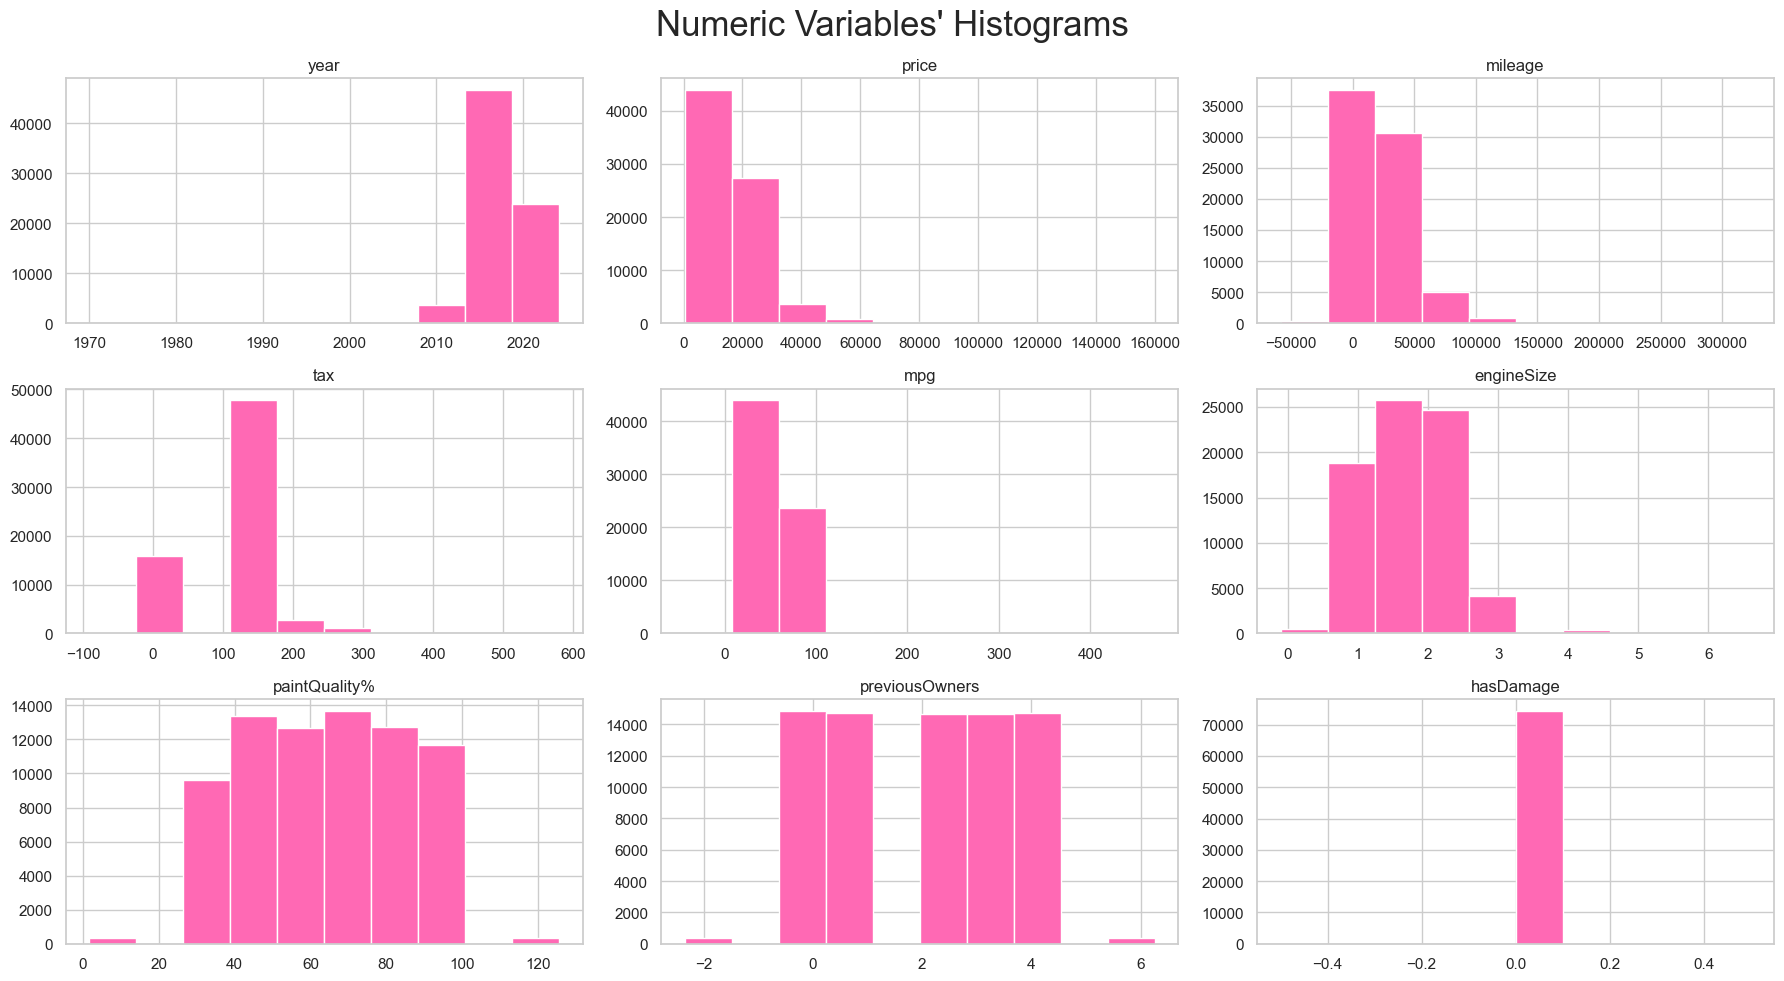

In [235]:
# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize=(18, 10))

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(df_train[feat], color = 'hotpink')
    ax.set_title(feat)

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')  

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms", fontsize=25)

plt.tight_layout()
plt.show()

**Boxplots**

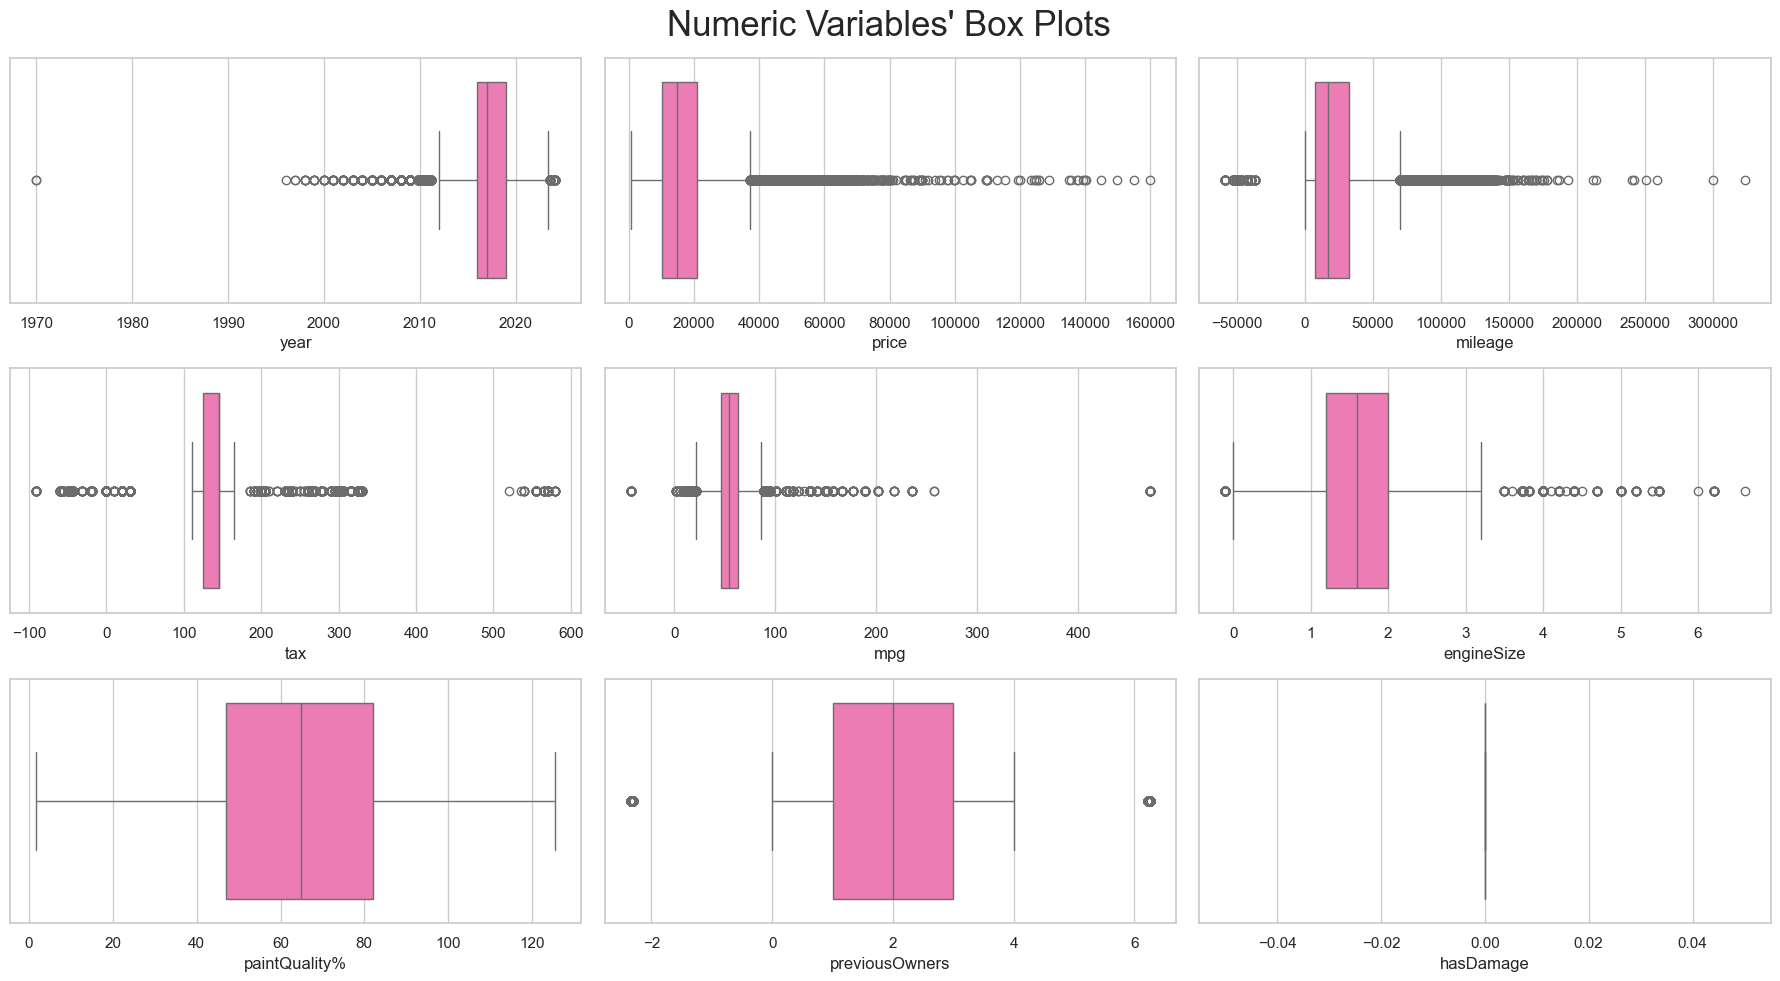

In [236]:
# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize = (18,10))

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df_train[feat], ax=ax, color='hotpink')

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Box Plots", fontsize=25)

plt.tight_layout()
plt.show()

paintQuality% and hasDamage appear to be the only features without outliers. hasDamage is a straight line only since it only has 0 ou NA.

The remaining features have a lot of outliers, and very extreme ones since the distribuition is very compressed.

**Correlations**

To measure the correlation between numerical variables we decided to use Spearman's coefficient, as it captures monotonic associations, not just linear ones. 

In [237]:
corr = df_train[numeric_features].corr(method="spearman")
corr = corr.round(2)
corr

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
year,1.00,0.60,-0.78,0.32,-0.31,-0.04,0.00,0.00,NaN
price,0.60,1.00,-0.51,0.31,-0.39,0.56,0.00,-0.00,NaN
mileage,-0.78,-0.51,1.00,-0.25,0.32,0.10,-0.00,0.00,NaN
tax,0.32,0.31,-0.25,1.00,-0.55,0.16,0.00,-0.00,NaN
mpg,-0.31,-0.39,0.32,-0.55,1.00,-0.20,0.00,0.00,NaN
engineSize,-0.04,0.56,0.10,0.16,-0.20,1.00,0.00,0.00,NaN
paintQuality%,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,-0.01,NaN
previousOwners,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.01,1.00,NaN
hasDamage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


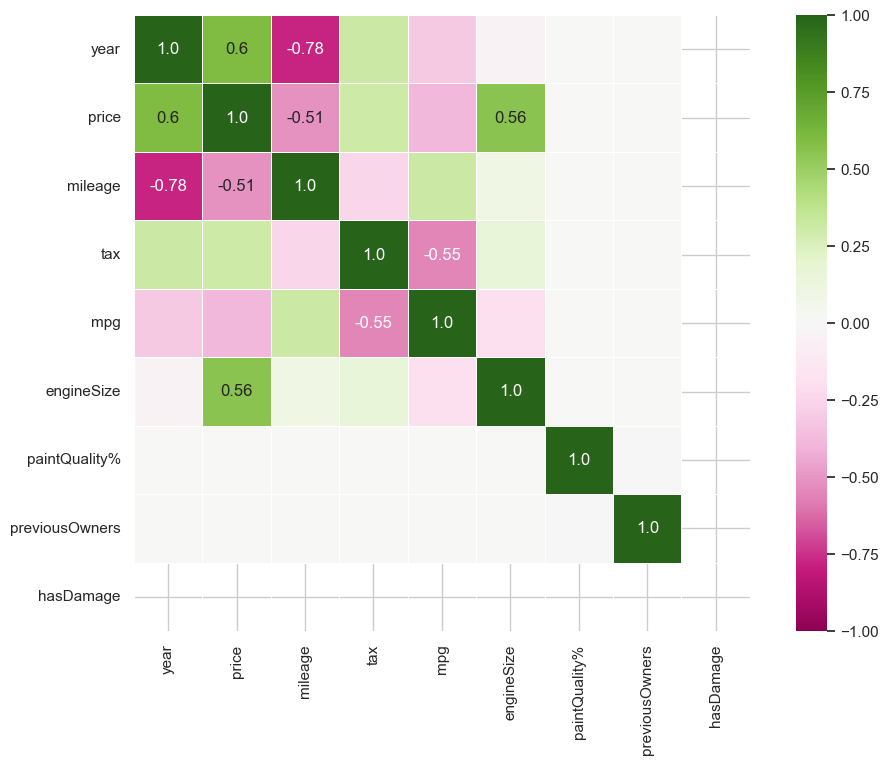

In [238]:
# Prepare figure
fig = plt.figure(figsize=(12, 8))

mask_annot = np.absolute(corr.values) >= 0.5 
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 


# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, 
            annot=annot, # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

plt.show()


'previousOwners' and 'paintQuality%' present almost no correlation with the remainder, which indicates some degree of irrelevance.

'mileage' and 'year' show strong correlation (in opposite directions).

'mpg' and 'tax' show medium correlation (in opposite directions).

'mpg' and 'year', 'tax' and 'mileage', 'tax' and 'year' show medium-low correlation.

The value of the correlations is probably affected by the amount of existing errors. 

**Bivariate plots**

## Data Preparation

### Pre processing the categorical variables for practicality

In [239]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())

### Hold Out Implementation

In [240]:
target = df_train['price']
data = df_train.drop(['price'], axis=1)

In [241]:
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                 target, 
                                                 test_size=0.2, 
                                                 random_state=15, 
                                                 shuffle=True)

### Categorical Variables Treatment

##### *Brands*

In [242]:
brands = X_train['Brand'].dropna().unique().tolist()
print(f' Typos in brands: {brands}')

 Typos in brands: ['VW', 'FORD', 'HYUNDAI', 'OPEL', 'TOYOT', 'MERCEDES', 'SKODA', 'BMW', 'TOYOTA', 'AUDI', 'PEL', 'FOR', 'AUD', 'BM', 'MERCEDE', 'UDI', 'V', 'YUNDAI', 'MW', 'ORD', 'W', 'OPE', 'HYUNDA', 'KODA', 'ERCEDES', 'SKOD', 'OYOTA', 'ERCEDE', 'OR', 'PE', 'UD', 'KOD', 'YUNDA']


In Brands we have the value 'W' which could mean VW or BMW. 

In [243]:
def correct_brand_w(df, brand, model):

    '''
    The function will switch the observations 'W' with 'BMW' and 'VW' depending on the correspondence of their
    models in other observations. This function is only applied to one element, one brand and the corresponding model

    Parameters
    -----------
    df : DataFrame
        the DataFrame whose columns are to be fixed
        
    brand : string
        the brand 

    model : string
        the corresponding model

    
    Returns
    -----------
    brand : string
        correct model, which will be 'BMW' or 'VW' if the brand is 'W', and the input brand otherwise
    

    '''

    # If the brand is 'w' and its a string
    if isinstance(brand, str) and brand == 'W':

        # For cicle to go over the brands and corresponding models in the DataFrame
        for brand_in_column, model_in_column in zip(df['Brand'], df['model']):

            # If the same model is found, then return the corresponding brand
            if isinstance(brand_in_column, str) and model_in_column == model and brand_in_column != 'W':
                print (brand_in_column)
                return brand_in_column
            
    # If the brand is not 'W', it remains the same           
    return brand

# Correct the  'W' values in the columns 'Brand' by applying the function correct_brand_w to all elements in the column
X_train['Brand'] = X_train.apply(lambda row: correct_brand_w(X_train, row['Brand'], row['model']), axis = 1)

V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [197]:
X_val['Brand'] = X_val.apply(lambda row: correct_brand_w(X_val, row['Brand'], row['model']), axis = 1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [198]:
df_test['Brand'] = df_test.apply(lambda row: correct_brand_w(df_test, row['Brand'], row['model']), axis = 1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [199]:
print(f'Train: {X_train[(X_train['Brand']=='W')]}\n\n')
print(f'Validation: {X_val[(X_val['Brand']=='W')]}\n\n')
print(f'Test: {df_test[(df_test['Brand']=='W')]}')

Train:       Brand model    year transmission  mileage fuelType    tax   mpg  \
carID                                                                   
74210     W   NaN  2019.0    SEMI-AUTO   3700.0   DIESEL  145.0  52.3   
66941     W   NaN  2019.0    AUTOMATIC   6000.0      NaN  145.0  37.7   

       engineSize  paintQuality%  previousOwners  hasDamage  
carID                                                        
74210         2.0           87.0             3.0        0.0  
66941         1.5           70.0             3.0        0.0  


Validation:       Brand model    year transmission  mileage fuelType    tax   mpg  \
carID                                                                   
65456     W   NaN  2019.0       MANUAL   3000.0   DIESEL  145.0  57.7   

       engineSize  paintQuality%  previousOwners  hasDamage  
carID                                                        
65456         1.6           38.0             2.0        0.0  


Test:        Brand model    ye

We can see that we fixed the problem with the brand 'w' except for the cases with null values, which are only 5 observations. The ones that were fixed were all 'VW' so we will assume the same for these.

In [200]:
X_train.loc[X_train['Brand'] =='W' ,'Brand'] = 'VW'

X_val.loc[X_val['Brand'] =='W' ,'Brand'] = 'VW'

df_test.loc[df_test['Brand'] =='W' ,'Brand'] = 'VW'

print(X_train[X_train['Brand'] =='W'], '\n\n')
print(X_val[X_val['Brand'] =='W'], '\n\n')
print(df_test[df_test['Brand'] =='W'])


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: [] 


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: [] 


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: []


For all variables, we will follow the same logic. We will group the typos into clusters based only on the typos from the **training data**. Then, we will correct the errors in training, validation and testing based on the created clusters. If any typo has no match, it will be converted to NA and handled later.

Lets correct the typos:

TheFuzz uses the Levenshtein edit distance to calculate the degree of closeness between two strings.

**Levenshtein distance** = at a minimum, how many edits are required to change one string into the other.

In [201]:
set([len(brand) for brand in brands])

{1, 2, 3, 4, 5, 6, 7, 8}

[https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings]

[https://medium.com/@laxmi17sarki/string-matching-using-fuzzywuzzy-24be9e85c88d]

**Ratio choice**: fuzz.WRatio, most robust method

In [202]:
from fuzzywuzzy import fuzz

# Creates clusters with similar brands
def create_clusters(brand_list, column, threshold=86): #groups strings with a similarity greater than or equal to treshold%. 
    clusters = []
    for brand in brand_list:
        found = False
        for cluster in clusters:
            # evaluates if brand is similar to any cluster
            if any(fuzz.WRatio(str(brand).lower(), str(b).lower()) >= threshold for b in cluster):
                cluster.append(brand)
                found = True
                break
        #if it doesn't find a match --> new cluster
        if not found:
            clusters.append([brand])

    # Gives the clusters names- chooses the most freq name
    mapping = {}
    counts = df_train[column].value_counts()
    for cluster in clusters:
        mode = max(cluster, key=lambda x: counts.get(x,0))  #finds the "max" in the cluster according to the key --> mode
        for brand in cluster:
            mapping[brand] = str(mode.upper())

    return clusters, mapping

clusters, mapping = create_clusters(brands, 'Brand', threshold=85)

print("Clusters:")
for c in clusters:
    print(c)

X_train['Brand_cleaned'] = X_train['Brand'].map(mapping)
X_val['Brand_cleaned'] = X_val['Brand'].map(mapping)
df_test['Brand_cleaned'] = df_test['Brand'].map(mapping)

print("\nCleaned brand - Train:")
print(X_train['Brand_cleaned'].dropna().unique())

print("\nCleaned brand - Validation:")
print(X_val['Brand_cleaned'].dropna().unique())

print("\nCleaned brand - Test:")
print(df_test['Brand_cleaned'].dropna().unique())



Clusters:
['VW', 'V', 'W']
['FORD', 'FOR', 'ORD', 'OR']
['HYUNDAI', 'YUNDAI', 'HYUNDA', 'YUNDA']
['OPEL', 'PEL', 'OPE', 'PE']
['TOYOT', 'TOYOTA', 'OYOTA']
['MERCEDES', 'MERCEDE', 'ERCEDES', 'ERCEDE']
['SKODA', 'KODA', 'SKOD', 'KOD']
['BMW', 'BM', 'MW']
['AUDI', 'AUD', 'UDI', 'UD']

Cleaned brand - Train:
['VW' 'FORD' 'HYUNDAI' 'OPEL' 'TOYOTA' 'MERCEDES' 'SKODA' 'BMW' 'AUDI']

Cleaned brand - Validation:
['BMW' 'OPEL' 'AUDI' 'MERCEDES' 'FORD' 'TOYOTA' 'VW' 'HYUNDAI' 'SKODA']

Cleaned brand - Test:
['HYUNDAI' 'VW' 'BMW' 'OPEL' 'FORD' 'MERCEDES' 'SKODA' 'TOYOTA' 'AUDI']


#### *Transmission*

In [203]:
transmission_types = X_train['transmission'].dropna().unique().tolist()
print(f' Typos in models: {transmission_types}')

 Typos in models: ['MANUAL', 'SEMI-AUTO', 'AUTOMATIC', 'UNKNOWN', 'ANUAL', 'EMI-AUTO', 'MANUA', 'SEMI-AUT', 'UTOMATIC', 'AUTOMATI', 'OTHER', 'UNKNOW', 'ANUA', 'NKNOWN', 'UTOMATI', 'EMI-AUT', 'NKNOW']


In [204]:
# Creates clusters with similar fuel types
clusters, mapping = create_clusters(transmission_types, 'transmission', threshold=86)

X_train['transmission_cleaned'] = X_train['transmission'].map(mapping)
X_val['transmission_cleaned'] = X_val['transmission'].map(mapping)
df_test['transmission_cleaned'] = df_test['transmission'].map(mapping)

print("Clusters:")
for c in clusters:
    print(c)

print("\nCleaned transmission - Train:")
print(X_train['transmission_cleaned'].dropna().unique())

print("\nCleaned transmission - Validation:")
print(X_val['transmission_cleaned'].dropna().unique())

print("\nCleaned transmission - Test:")
print(df_test['transmission_cleaned'].dropna().unique())

Clusters:
['MANUAL', 'ANUAL', 'MANUA', 'ANUA']
['SEMI-AUTO', 'EMI-AUTO', 'SEMI-AUT', 'EMI-AUT']
['AUTOMATIC', 'UTOMATIC', 'AUTOMATI', 'UTOMATI']
['UNKNOWN', 'UNKNOW', 'NKNOWN', 'NKNOW']
['OTHER']

Cleaned transmission - Train:
['MANUAL' 'SEMI-AUTO' 'AUTOMATIC' 'UNKNOWN' 'OTHER']

Cleaned transmission - Validation:
['SEMI-AUTO' 'MANUAL' 'AUTOMATIC' 'UNKNOWN' 'OTHER']

Cleaned transmission - Test:
['AUTOMATIC' 'SEMI-AUTO' 'MANUAL' 'UNKNOWN' 'OTHER']


#### *Fuel Types*

In [205]:
fuel_types=X_train['fuelType'].dropna().unique().tolist()
print(f' Typos in models: {fuel_types}')

 Typos in models: ['PETROL', 'PETRO', 'DIESEL', 'HYBRID', 'DIESE', 'ETROL', 'IESEL', 'YBRID', 'OTHER', 'HYBRI', 'ETRO', 'THER', 'IESE', 'ELECTRIC', 'OTHE', 'YBRI']


In [206]:
# Creates clusters with similar fuel types
clusters, mapping = create_clusters(fuel_types, 'fuelType', threshold=85)

X_train['fuelType_cleaned'] = X_train['fuelType'].map(mapping)
X_val['fuelType_cleaned'] = X_val['fuelType'].map(mapping)
df_test['fuelType_cleaned'] =  df_test['fuelType'].map(mapping)
print("Clusters:")
for c in clusters:
    print(c)

print("\nCleaned fuel type - Train:")
print(X_train['fuelType_cleaned'].dropna().unique())

print("\nCleaned fuel type - Validation:")
print(X_val['fuelType_cleaned'].dropna().unique())

print("\nCleaned fuel type - Test:")
print(df_test['fuelType_cleaned'].dropna().unique())

Clusters:
['PETROL', 'PETRO', 'ETROL', 'ETRO']
['DIESEL', 'DIESE', 'IESEL', 'IESE']
['HYBRID', 'YBRID', 'HYBRI', 'YBRI']
['OTHER', 'THER', 'OTHE']
['ELECTRIC']

Cleaned fuel type - Train:
['PETROL' 'DIESEL' 'HYBRID' 'OTHER' 'ELECTRIC']

Cleaned fuel type - Validation:
['DIESEL' 'PETROL' 'HYBRID' 'OTHER']

Cleaned fuel type - Test:
['PETROL' 'DIESEL' 'HYBRID' 'OTHER' 'ELECTRIC']


#### *Models*

In [207]:
models= X_train['model'].dropna().unique().tolist()
print(f'Nº of unique values: {len(models)}')

Nº of unique values: 288


In [208]:
set([len(str(model)) for model in models])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21}

Fuzzywuzzy wasnt able to group the same models in the column 'model', so for this case we will use get_close_matches from difflib:

In [209]:
def similar_models(models, threshold = 0.85):

    # This list, which starts as an empty list, will store the similar groups of strings
    similar_groups = []
    
    # Start a for loop that will go over all the values in models
    for model in models:

        # Transform de list of lists in a unique list with all the values in the sublists
        similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

        if model in similar_groups_flat:

            # If the model is already in similar_groups_flat, then it already has its similarity group, no need to serach for more
            continue
        else:
             
             # Calculate the similarity between model and the other observations and keep the ones with a similarity higher than 0.85
             close_matches = get_close_matches(model, models, cutoff=threshold)

             model_prefix =  model.split(" ")[0] 
             
             # For the models with more than one word it is necessary to evaluate the prefix in order to separate them well
             if " " in model:

                # Only keep the models with the same model code/ prefix. Different model codes belong to different models
                close_matches = [match for match in close_matches if match.split(" ")[0] == model_prefix]

            # Add the close matches to the list of similar groups
             similar_groups.append(close_matches)

    return similar_groups

clusters = similar_models (models)

print("Clusters:")
for c in clusters:
    print(c)

Clusters:
['T-ROC', 'T-RO']
['FIESTA', 'FIEST']
['GOLF', 'GOL']
['CORS', 'CORSA']
['AYG', 'AYGO']
['SLK']
['FABIA', 'FABI']
['UP']
['1 SERIES', '1 SERIE']
['KUGA', 'KUG']
['FOCU', 'FOCUS']
['TT']
['A4']
['SL CLASS', 'SL CLAS']
['4 SERIES', '4 SERIE']
['X3']
['SUPERB', 'SUPER']
['OCTAVIA', 'OCTAVI']
['C CLASS', 'C CLAS']
['A3']
['TIGUAN', 'TIGUA']
['V CLASS', 'V CLAS']
['PRIUS']
['Q5']
['GLC CLASS', 'GLC CLAS']
['MOKKA X']
['VIVA', 'VIV']
['ASTRA', 'ASTR']
['A5']
['CL CLASS']
['A1']
['ZAFIRA', 'ZAFIR']
['2 SERIES', '2 SERIE']
['POLO', 'POL']
['5 SERIES', '5 SERIE']
['AURIS', 'AURI']
['A8']
['ECOSPORT', 'ECOSPOR']
['I30']
['INSIGNIA', 'INSIGNI']
['PUMA']
['SCALA', 'SCAL']
['E CLASS', 'E CLAS']
['KA+']
['A CLASS', 'A CLAS']
['YARIS', 'YARI']
['3 SERIE', '3 SERIES']
['MOKKA', 'MOKK']
['KODIAQ', 'KODIA']
['SHUTTLE']
['Q7']
['Q3']
['GT86']
['ADAM', 'ADA']
['CROSSLAND X', 'CROSSLAND']
['GLA CLASS', 'GLA CLAS']
['RS6']
['GRAND C-MAX', 'GRAND C-MA']
['GALAXY', 'GALAX']
['KONA', 'KON']
['CITIGO'

In [210]:
# Calculate counts ONCE before the function
model_counts = df_train['model'].value_counts().to_dict()

# Create a lookup dictionary for faster group matching
correct_models = []
model_mapping = {}
for group in clusters:
    best_model = max(group, key=lambda x: model_counts.get(x, 0))
    correct_models.append(best_model)
    for model in group:
        model_mapping[model] = best_model



def correct_column_model(model, similar_groups, threshold = 0.85):

    # If the element is NA or an empty string then nothing is changed
    if pd.isna(model) or model == ' ':
        return model
    
    # If the model has only one character then it is not possible to associate it with any model so return NA
    elif len(model) == 1:
        return np.nan

    # Transform de list of lists in a unique list with all the values in the sublists
    similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

    if model in similar_groups_flat:
        return model_mapping[model]
    
    else:
        best_match = get_close_matches(model, correct_models, n=1, cutoff = threshold)

        if best_match:
            return best_match[0]
        
        else:
            return model


X_train['model_cleaned'] = X_train['model'].apply(lambda x: correct_column_model(x, clusters))
X_val['model_cleaned'] = X_val['model'].apply(lambda x: correct_column_model(x, clusters))
df_test['model_cleaned'] =  df_test['model'].apply(lambda x: correct_column_model(x, clusters))

In [215]:
correct_column_model('HILU', clusters)

'HILUX'

In [212]:

print("\nCleaned model - Train:")
print(X_train['model_cleaned'].dropna().unique())

print("\nCleaned model - Validation:")
print(X_val['model_cleaned'].dropna().unique())

print("\nCleaned model - Test:")
print(df_test['model_cleaned'].dropna().unique())


Cleaned model - Train:
['T-ROC' 'FIESTA' 'GOLF' 'CORSA' 'AYGO' 'SLK' 'FABIA' 'UP' '1 SERIES'
 'KUGA' 'FOCUS' 'TT' 'A4' 'SL CLASS' '4 SERIES' 'X3' 'SUPERB' 'OCTAVIA'
 'C CLASS' 'A3' 'TIGUAN' 'V CLASS' 'PRIUS' 'Q5' 'GLC CLASS' 'MOKKA X'
 'VIVA' 'ASTRA' 'A5' 'CL CLASS' 'A1' 'ZAFIRA' '2 SERIES' 'POLO' '5 SERIES'
 'AURIS' 'A8' 'ECOSPORT' 'I30' 'INSIGNIA' 'PUMA' 'SCALA' 'E CLASS' 'KA+'
 'A CLASS' 'YARIS' '3 SERIES' 'MOKKA' 'KODIAQ' 'SHUTTLE' 'Q7' 'Q3' 'GT86'
 'ADAM' 'CROSSLAND X' 'GLA CLASS' 'RS6' 'GRAND C-MAX' 'GALAXY' 'KONA'
 'CITIGO' 'I10' 'I20' 'T-CROSS' 'X1' 'C-MAX' 'COROLLA' 'X2' 'TOUAREG'
 'GLE CLASS' 'X6' 'TUCSON' 'PASSAT' 'A6' 'M4' 'S4' 'YETI OUTDOOR'
 'GRANDLAND X' 'TOURNEO CUSTOM' 'GL CLASS' 'ARTEON' 'B CLASS' 'IX35' 'KA'
 'C-HR' 'MONDEO' 'IX20' 'TOURAN' 'X-CLASS' 'CLS CLASS' 'IONIQ' 'RS5'
 'S CLASS' 'HILUX' 'GLS CLASS' 'Q2' 'RAV4' 'YETI' 'KAROQ' 'S8' 'CLA CLASS'
 'GOLF SV' 'SCIROCCO' 'M CLASS' 'MERIVA' 'RAPID' 'B-MAX' 'EDGE' 'SHARAN'
 '7 SERIES' 'TIGUAN ALLSPACE' 'GRAND TOURNEO 

### Numerical Variables Treatment

In [ ]:
invalid = ((X_train['year']>2020) | (X_train['mileage']<0) | (X_train['tax']<0) | 
           (X_train['mpg']<=0) | (X_train['paintQuality%']>100) | (X_train['previousOwners']< 0) | (X_train['engineSize']<= 0))


invalid_ratio = round(X_train[invalid].shape[0]/ X_train.shape[0] * 100,2)

print(f"Rows with invalid values account for {invalid_ratio}% of the train dataset.")

Rows with invalid values account for 2.78% of the train dataset.


## Modeling

We will start by implementing a Linear Regression model

In [ ]:
train_index_drop = X_train.index[X_train.isna().any(axis=1)]
val_index_drop = X_val.index[X_val.isna().any(axis=1)]
X_train = X_train.drop(train_index_drop)
y_train = y_train.drop(train_index_drop)
X_val = X_val.drop(val_index_drop)
y_val = y_val.drop(val_index_drop)


In [ ]:
X_train = X_train.loc[:,['year','mileage', 'tax', 'mpg','engineSize', 'paintQuality%', 'previousOwners']]
X_val = X_val.loc[:,['year','mileage', 'tax', 'mpg','engineSize', 'paintQuality%', 'previousOwners']]

In [ ]:
linear_regression = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=1.0, max_iter=10000)
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000)

In [ ]:
linear_regression.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
elastic_net_model.fit(X_train, y_train)

,alpha,1.0
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,10000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [ ]:
y_pred_linear_train = linear_regression.predict(X_train)
y_pred_linear_val = linear_regression.predict(X_val)
y_pred_ridge_train = ridge_model.predict(X_train)
y_pred_ridge_val = ridge_model.predict(X_val)
y_pred_lasso_train = lasso_model.predict(X_train)
y_pred_lasso_val = lasso_model.predict(X_val)
y_pred_elastic_net_train = elastic_net_model.predict(X_train)
y_pred_elastic_net_val = elastic_net_model.predict(X_val)

In [ ]:
# Here we can compare the  predictions from the different models
real_vs_pred_val = pd.DataFrame({'y_true': y_val.values.flatten(), 'y_pred_linear': y_pred_linear_val.flatten(), 'y_pred_ridge': y_pred_ridge_val, 'y_pred_lasso' : y_pred_lasso_val, 'y_pred_elastic_net': y_pred_elastic_net_val}, 
                           index=y_val.index #ensures we can map the predictions to each observation correctly
                           )
real_vs_pred_val

,y_true,y_pred_linear,y_pred_ridge,y_pred_lasso,y_pred_elastic_net
carID,,,,,
14278,29950,24928.554430,24928.206001,24927.515852,22054.858468
56641,10698,18643.492149,18643.752811,18644.565163,20585.096580
2172,16490,11063.960210,11064.320052,11064.942107,13959.524353
59953,9999,14179.706801,14179.780473,14180.685447,14658.759215
38177,36995,25791.202345,25790.938897,25790.836611,23602.723289
...,...,...,...,...,...
23128,18000,18095.272668,18095.482877,18096.013656,19759.317604
70196,13990,12065.461868,12066.028199,12066.711337,16570.497703
36581,32995,24961.335784,24960.963976,24958.743925,21893.506217


In [ ]:
print(f"\nIntercept Linear Model: {linear_regression.intercept_:.2f}")
print(f"\nIntercept Ridge Model: {ridge_model.intercept_:.2f}")
print(f"\nIntercept Lasso Model: {lasso_model.intercept_:.2f}")
print(f"\nIntercept Elastic Net Model: {elastic_net_model.intercept_:.2f}")


Intercept Linear Model: -3058751.57

Intercept Ridge Model: -3058740.20

Intercept Lasso Model: -3058055.30

Intercept Elastic Net Model: -2669792.40


In [ ]:
linear_coefs = pd.DataFrame({'coef_linear': linear_regression.coef_, 'coef_ridge': ridge_model.coef_, 'coef_lasso': lasso_model.coef_, 'coef_elast': elastic_net_model.coef_}, 
                           index=X_train.columns)
linear_coefs

,coef_linear,coef_ridge,coef_lasso,coef_elast
year,1517.878350,1517.873409,1517.536369,1330.696352
mileage,-0.096478,-0.096474,-0.096485,-0.078037
tax,0.635889,0.637558,0.643137,14.240831
mpg,-34.593834,-34.598669,-34.608549,-73.000753
engineSize,10884.265135,10883.405265,10880.889976,4012.544854
paintQuality%,-3.684652,-3.684525,-3.682187,-2.648833
previousOwners,9.034819,9.035310,8.581079,11.958104


In [ ]:
def adjusted_r2 (r2,n,p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [ ]:
n_train = len(y_train)
p_train = len(X_train.columns)

n_val = len(y_val)
p_val = len(X_val.columns)

In [ ]:
# Create comparison dataframe
comparison_models = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'Elastic net'],
    'Train R²': [
        r2_score(y_train, y_pred_linear_train),
        r2_score(y_train, y_pred_ridge_train),
        r2_score(y_train, y_pred_lasso_train),
        r2_score(y_train, y_pred_elastic_net_train)
    ],
    'Val R²': [
        r2_score(y_val, y_pred_linear_val),
        r2_score(y_val, y_pred_ridge_val),
        r2_score(y_val, y_pred_lasso_val),
        r2_score(y_val, y_pred_elastic_net_val)
    ],
    'Train Adjusted R²': [
        adjusted_r2(r2_score(y_train, y_pred_linear_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_ridge_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_lasso_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_elastic_net_train), n_train, p_train)
    ],
    'Val Adjusted R²': [
        adjusted_r2(r2_score(y_val, y_pred_linear_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_ridge_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_lasso_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_elastic_net_val), n_val, p_val)
    ],
    'Train MAE': [
        mean_absolute_error(y_train, y_pred_linear_train),
        mean_absolute_error(y_train, y_pred_ridge_train),
        mean_absolute_error(y_train, y_pred_lasso_train),
        mean_absolute_error(y_train, y_pred_elastic_net_train)
    ],
    'Val MAE': [
        mean_absolute_error(y_val, y_pred_linear_val),
        mean_absolute_error(y_val, y_pred_ridge_val),
        mean_absolute_error(y_val, y_pred_lasso_val),
        mean_absolute_error(y_val, y_pred_elastic_net_val)
    ],
    'Train RMSE': [
        root_mean_squared_error(y_train, y_pred_linear_train),
        root_mean_squared_error(y_train, y_pred_ridge_train),
        root_mean_squared_error(y_train, y_pred_lasso_train),
        root_mean_squared_error(y_train, y_pred_elastic_net_train)
    ],
    'Val RMSE': [
        root_mean_squared_error(y_val, y_pred_linear_val),
        root_mean_squared_error(y_val, y_pred_ridge_val),
        root_mean_squared_error(y_val, y_pred_lasso_val),
        root_mean_squared_error(y_val, y_pred_elastic_net_val)
    ],
    'Train MedAE': [
        median_absolute_error(y_train, y_pred_linear_train),
        median_absolute_error(y_train, y_pred_ridge_train),
        median_absolute_error(y_train, y_pred_lasso_train),
        median_absolute_error(y_train, y_pred_elastic_net_train)
    ],
    'Val MedAE': [
        median_absolute_error(y_val, y_pred_linear_val),
        median_absolute_error(y_val, y_pred_ridge_val),
        median_absolute_error(y_val, y_pred_lasso_val),
        median_absolute_error(y_val, y_pred_elastic_net_val)
    ],
    'Train MAPE': [
        mean_absolute_percentage_error(y_train, y_pred_linear_train),
        mean_absolute_percentage_error(y_train, y_pred_ridge_train),
        mean_absolute_percentage_error(y_train, y_pred_lasso_train),
        mean_absolute_percentage_error(y_train, y_pred_elastic_net_train)
    ],
    'Val MAPE': [
        mean_absolute_percentage_error(y_val, y_pred_linear_val),
        mean_absolute_percentage_error(y_val, y_pred_ridge_val),
        mean_absolute_percentage_error(y_val, y_pred_lasso_val),
        mean_absolute_percentage_error(y_val, y_pred_elastic_net_val)
    ],
})

print("Model Comparison:")
comparison_models

Model Comparison:


,Model,Train R²,Val R²,Train Adjusted R²,Val Adjusted R²,Train MAE,Val MAE,Train RMSE,Val RMSE,Train MedAE,Val MedAE,Train MAPE,Val MAPE
0,OLS,0.662125,0.648134,0.662071,0.647907,3791.597341,3962.039233,5656.041355,6210.110640,2772.252223,2855.142963,0.283865,0.284358
1,Ridge,0.662125,0.648131,0.662071,0.647904,3791.574275,3962.028314,5656.041374,6210.140105,2772.705055,2854.642694,0.283861,0.284354
2,Lasso,0.662125,0.648124,0.662071,0.647897,3791.510673,3961.997367,5656.041722,6210.199690,2772.330675,2855.858200,0.283842,0.284338
3,Elastic net,0.515181,0.491600,0.515103,0.491272,4557.151693,4779.067839,6775.239858,7464.723231,3414.617505,3523.233818,0.323112,0.327522


The higher the R2 the better the model fits the data. It measures the amount of variance in the target that can be explained by the model. It always increases with the number of independent variables so I compute the adjusted R2 to confirm that we are not putting too many features in the model. For the following metrics, the closer to 0.0 the better.

Now to explain the how distance our prediction is from the true value we will use MAE, its a good metric and it is also the metric that will be used to evaluate the results in the kaggle competition. The best possible value is 0.0. Measures Errors in an Uniform Manner: Useful in problems where the magnitude of the error is not particularly relevant (although this particular point  is a disadvantage when magnitude is relevant). Since our goal is to predict car prices the magnitude of the error is a big factor, it is very differnt to predict a price of 2000 and 20000. 

For interpretability purposes and because it is easily communicated to stakeholders, we will also compute MAPE. One of the disadvantages of this metric is that when actual values are close to zero, even small absolute errors can result in very large percentage errors, but in the train data set at least, the minimum value of the target is 450, so we will not encounter this problem.

To adress the problem with MAE we will also compute RSME, however we need to consider that this metric is very sensitive to outliers and that it lacks interpretabibilty

IMPORTANT!!! Plot the distribuition of the errors, if it is skewed or contains extreme values we should use Median Absolute Error. Its very useful also in the presence of outliers which is the case of this data set.

In [ ]:
residuals = y_val - y_pred_linear_val

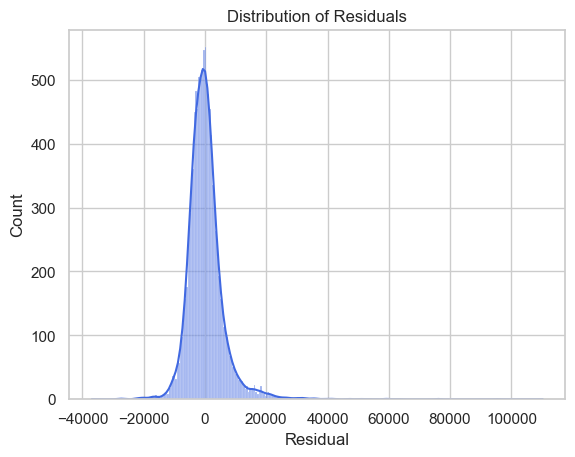

In [ ]:
sns.set_style("whitegrid")
sns.histplot(residuals, kde=True, color="royalblue")
plt.xlabel("Residual")
plt.title("Distribution of Residuals")
plt.show()

Centered around 0 → means the model’s predictions are unbiased (it doesn’t systematically over- or under-estimate)

Roughly symmetric and bell-shaped → suggests residuals are approximately normally distributed, which is ideal for linear regression assumptions.

Slight tail on the right (positive side) → indicates a few large positive errors — the model occasionally underestimates high prices (typical in price prediction problems).

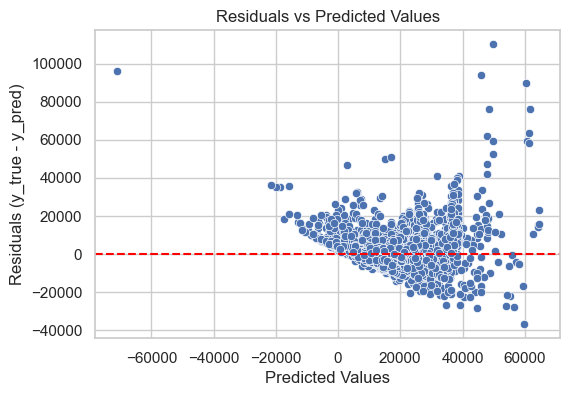

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_linear_val, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values")
plt.show()

## Deployment